In [1]:
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
train_data = pd.read_csv('./Datasets/train.csv')
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [3]:
train_data['label'] = train_data['healthy'].map(str)+\
                      train_data['multiple_diseases'].map(str)+\
                      train_data['rust'].map(str)+\
                      train_data['scab'].map(str)
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,0001
1,Train_1,0,1,0,0,0100
2,Train_2,1,0,0,0,1000
3,Train_3,0,0,1,0,0010
4,Train_4,1,0,0,0,1000


In [4]:
def load_image(image_id):
    image = cv2.imread(f"./Datasets/images/{image_id}.jpg")
    return image_id, cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = pd.DataFrame(
    train_data["image_id"][:30].progress_apply(load_image).tolist()
)
train_images.columns = ["image_id", "image"]

100%|██████████| 30/30 [00:01<00:00, 17.60it/s]


In [5]:
train_images['height'] = train_images['image'].apply(lambda img : img.shape[0])
train_images['width'] = train_images['image'].apply(lambda img : img.shape[1])

In [6]:
train_data = pd.merge(train_data, train_images, on=['image_id'])

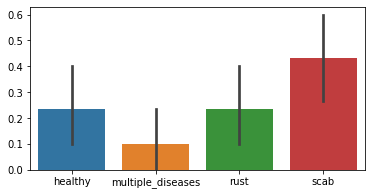

In [7]:
plt.figure(figsize=(6, 3))
sns.barplot(data=train_data[['healthy', 'multiple_diseases', 'rust', 'scab']])

In [8]:
def show_img(images, n):
    fig, ax = plt.subplots(int(n/2), 2, figsize=(8, 16))
    for i in range(0,min(n, images.shape[0])):
        ax[i].imshow(images.iloc[i]['image'])
        ax[i].set_title(images.iloc[i]['image_id'])

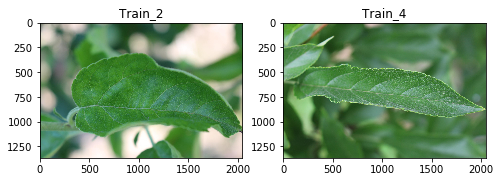

In [9]:
show_img(train_data.query('healthy==1'), 2)

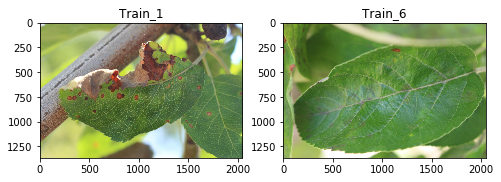

In [10]:
show_img(train_data.query('multiple_diseases==1'), 2)

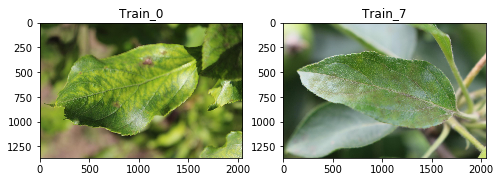

In [11]:
show_img(train_data.query('scab==1'), 2)

In [12]:
#show_img(train_data.query('rust==1'), 2)

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.25,
    brightness_range=[0.5, 1.5],
    validation_split=0.2,
    preprocessing_function= lambda img : cv2.blur(img,(5,5)))

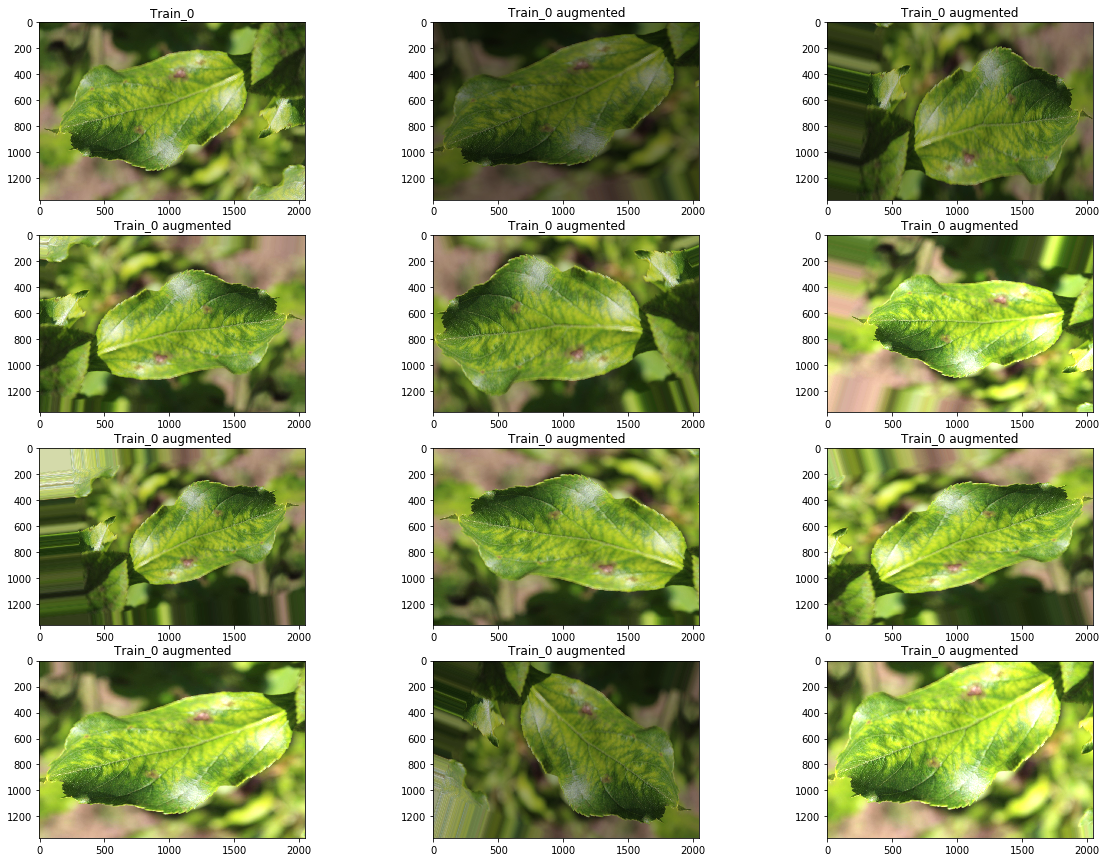

In [14]:
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
ax[0][0].imshow(train_data.iloc[0]['image'])
ax[0][0].set_title(train_data.iloc[0]['image_id'])
for i in range(1,12):
    gen_img = img_gen.random_transform(train_data.iloc[0]['image'], seed=np.random.randint(i,100))
    ax[int(i/3)][i%3].imshow(gen_img.astype('uint8'))
    ax[int(i/3)][i%3].set_title(f"{train_data.iloc[0]['image_id']} augmented")

In [15]:
train_data['file_name'] = train_data['image_id']+'.jpg'
train_gen = img_gen.flow_from_dataframe(
                    dataframe=train_data,
                    target_size=(64, 64),
                    x_col='file_name',
                    directory="Datasets/images",
                    y_col="label",
                    batch_size=2,
                    subset='training'
)

validation_gen = img_gen.flow_from_dataframe(
                    dataframe=train_data,
                    target_size=(64, 64),
                    x_col='file_name',
                    directory="./Datasets/images/",
                    y_col="label",
                    batch_size=2,
                    subset='validation'
)

Found 24 validated image filenames belonging to 4 classes.
Found 6 validated image filenames belonging to 4 classes.


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizers='adam',
loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
model.fit_generator(
    generator=train_gen,
    validation_data=validation_gen,
    steps_per_epoch=8,
    epochs=10
)